# R Workshop 7

October 18, 2017

## Review

In the last workshop we began exploring the **dplyr** package
which is part of the *tidyverse*.  We started with the `filter`
function introduced in **R for Data Science**.

<http://r4ds.had.co.nz/transform.html#filter-rows-with-filter>

Let's review by working some exercises from Section `5.2.4` that
apply to the `flights` data set.

In [24]:
library(nycflights13)
library(tidyverse)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


### Missing `dep_time`

`filter(flights, is.na(dep_time))` has 8,255 rows.  These are probably flights
that were cancelled.

## More Dplyr Functions

In the last workshop we introduced **dplyr** through the function

* `filter` - restrict returned rows

Starting with

<http://r4ds.had.co.nz/transform.html#arrange-rows-with-arrange>

of **R for Data Science**, work through Section `5.6.1`.  This
will cover the following **dplyr** functions.

* `arrange` - sort rows
* `select`  - restrict return columns
* `mutate`  - compute new columns
* `transmutate` - replace with computed columns
* `summarize` - perform row reduction through summaries
* `group_by` - control grouping using by `summarize`.
* `%>%` - introduce the overloaded piping operator

## Statistics

1. Review the Gamma distribution.
2. Find the Gamma moment generating function.  The
   [homework handouts](https://github.com/lacounty-isab/workshops/blob/master/ds/r/hw01.pdf)
   provide some preparation for this.
   The Gamma distribution pops up in calculations we'll perform
   later with statistical distributions.
3. MGF (Moment Generating Function) for linear combinations of random variables.
4. Linear combinations of the exponential.

## More ggplot

Last time we were introduced to `ggplot`.
We produced a nice plot with some funny syntax.

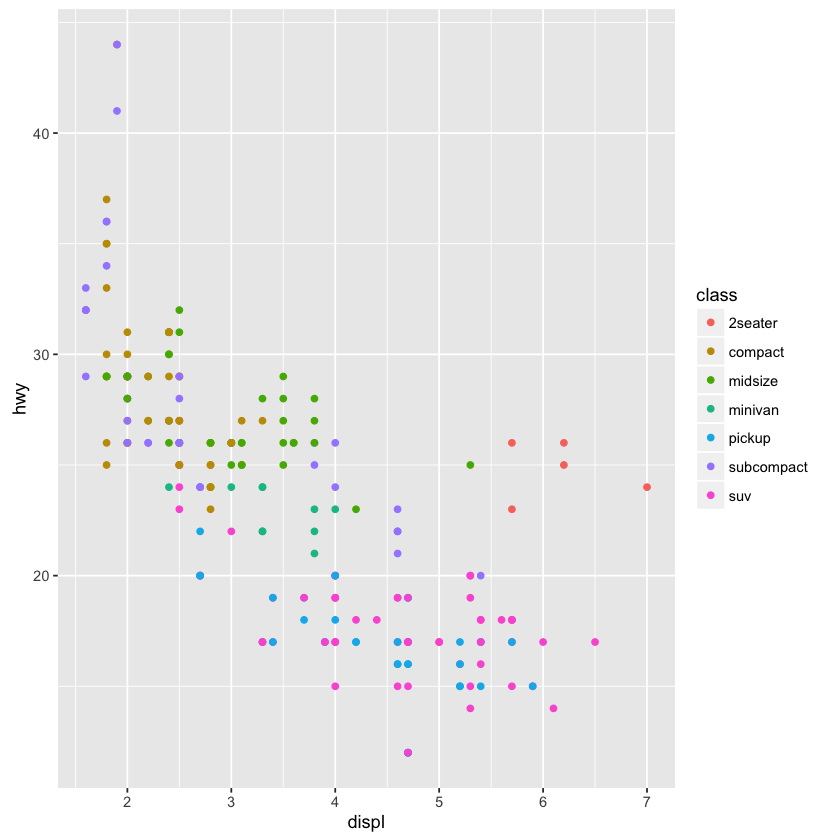

In [25]:
ggplot(data=mpg) + geom_point(mapping=aes(x=displ, y=hwy, color=class))

Let's dig into the syntax to understand it better and consider
what benefits it may have.  First notice the plus sign, `+`, as
if we're adding two numbers together.  This is an example of
*operator overloading*.  The developers of **ggplot** have overloaded
the `+` operator to represent **layering** of plot components.

In the above example, there are only two layers.  The first layer
assigns the data frame that is the source of the data.  This implies
that the source dataset for **ggplot** is always a `data.frame` object;
and this is true.  Only `data.frame` objects can be plotted with
**ggplot**.  Most **ggplot** invocations will start with a call to the
`ggplot` function passing in the source `data.frame` object.  At this
point we've provided no information on which parts to render or how
to render it.

The next layer will generally be a **geom** (pronounced GEE-ohm).
It's short for "geometry" and represents of type of plot.  The
`geom_point` function plots points; the `geom_line` function plots
lines.  A rendering can have several geom layers.  The most important
parameter to a geom function is the **aesthetic**.  The aesthetic
determines which elements of the data frame are mapped to aesthetics
of the geom.  The most common aesthetics are `x` and `y` positions.
But as we saw in the example above, `color` is also useful.

Look at Exercise `1` of Section `3.3.1` in
[R for Data Science](http://r4ds.had.co.nz/data-visualisation.html#aesthetic-mappings).
This is a good way to avoid a common misunderstanding.

```
geom_point(mapping = aes(x = displ, y = hwy, color = "blue"))
```

Someone might think this should make all points blue.
But an assignment within an aesthetic **always** applies to the
underlying data frame.  In this case, it looks for a column in
the data frame named `blue` and attempt to set the color based
on this (likely non-existing) content.  The intention was probably

```
geom_point(mapping = aes(x = displ, y = hwy), col = "blue")
```

Notice how the color assignment was done **outside** the `aes`
function, but still within the `geom_point` function.

Now read through Sections
[3.5](http://r4ds.had.co.nz/data-visualisation.html#facets)
and
[3.6](http://r4ds.had.co.nz/data-visualisation.html#geometric-objects)
of the **R for Data Science** Visualization section.

## R Studio

Let's do some work in R Studio and see how it helps us go from
free exploration to scripting to documented analysis.
We'll explore some data from the LA County Sheriff's Open Data Portal.
This data is made available through JSON over HTTP.  Details are
provided at the following URL.

<https://dev.socrata.com/foundry/data.lacounty.gov/uvdj-ch3p>

We'll use the **httr** package to invoke the API and parse the
JSON.  The tricky part will involve converting the JSON to a
data frame.

In [7]:
library(httr)
response <- GET('https://data.lacounty.gov/',
                path='resource/uvdj-ch3p',
                query=list('$limit'='5'),
                add_headers(accept='application/json'))
response$status_code

[1] 200

If the status code is anything other than `200`, we need provide
additional handling.  Anything `400` and above usually means an error.
The `content` function is part of the **httr** package.  It uses the
`Content-Type` response header as a clue on how to parse the content.
In the present case, we expect the content type to be `application/json`,
which will cause the `content` function to parse the response as JSON.
The result will be a list of top level JSON elements, one for each row.

In [8]:
result_rows <- content(response)
length(result_rows)

[1] 5

The number of result rows should equal the limit we placed in the API's URL.
In this case, this is `5`.

We are presented with a few challenges when trying to wedge `result_rows`
into a data frame.

1. The first is that `result_rows` is organized by rows.
   Each top level element is a row.  But an R `data.frame`, internally,
   is a list of columns.  In order to convert `result_rows` to a
   `data.frame` we need to somehow exchange rows and columns.

2. Not all rows in `result_rows` have the same columns.  Moreover, some
   columns have values which are themselves lists.  We need to determine
   which columns we want and handle missing values.

Let's review the available columns by printing the names of the first row.

In [9]:
names(result_rows[[1]])

[1] "city"                         "crime_category_description"  
 [3] "crime_category_number"        "crime_date"                  
 [5] "crime_identifier"             "crime_year"                  
 [7] "gang_related"                 "geo_location"                
 [9] "geo_location_address"         "geo_location_city"           
[11] "geo_location_state"           "geo_location_zip"            
[13] "latitude"                     "longitude"                   
[15] "reporting_district"           "state"                       
[17] "station_identifier"           "station_name"                
[19] "statistical_code"             "statistical_code_description"
[21] "street"                       "victim_count"                
[23] "zip"

This is somewhat haphazard since this row could be missing columns.
We're going to choose from this list the columns we want to handle.

In [10]:
our_columns <- names(result_rows[[1]])[c(1:5, 7, 15:23)]
our_columns

[1] "city"                         "crime_category_description"  
 [3] "crime_category_number"        "crime_date"                  
 [5] "crime_identifier"             "gang_related"                
 [7] "reporting_district"           "state"                       
 [9] "station_identifier"           "station_name"                
[11] "statistical_code"             "statistical_code_description"
[13] "street"                       "victim_count"                
[15] "zip"

`result_rows` is a list of lists.  Each top level element
is a row.  The "inner list" is the set of named columns.
We want to create the opposite: a list of columns, each
element of which is an atomic vector (*atomic* means
"same type for all elements).  Given a column name, we
can create it's atomic vector with the following function.

```
sapply(result_rows, function(row) { row[[col_name]] }
```

The `sapply` function iterates over a list and does something
with each element.  It has two arguments.

1. a list
2. a function to be applied to each element of the list

The result is a new list with the same number of elements as
the first argument.  The value of each element is the
result of calling the function from the second argument.
The `s` in the name of `sapply` means *simplify if possible*.
This means that if the resulting list contains primitive elements
of the same type, the list is converted to a vector before returning.
Otherwise it's left as a new list.

Recall the second challenge described above: not all rows have all
columns.  When a column is missing, `result_row['col_name']` will
return `NULL`.  This will cause the lengths of the column vectors
to be unequal (which will cause the conversion to a `data.frame` to
fail).  To maintain placeholders for missing elements, we assign `NA`
instead of `NULL`.

```
sapply(result_rows, function(row) { 
    if ( is.null(row[[col_name]]) ) 
       NA
    else
       row[[col_name]] 
    })
```

This will assign `NA` if the value is `NULL`, or the value if
it is not `NULL`.  Let's see this in action.  First let's
apply it to a column with no `NULL` values to see the simple case.

In [15]:
col_name <- 'crime_identifier'
sapply(result_rows, function(row) { row[[col_name]] })

[1] "18351963" "18355628" "18274453" "18245488" "18307448"

In [16]:
col_name <- 'zip'
sapply(result_rows, function(row) { row[[col_name]] })

[[1]]
[1] "93536"

[[2]]
[1] "90262"

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

In [18]:
sapply(result_rows, function(row) { 
    if (is.null(row[[col_name]]))
        NA
    else
        row[[col_name]]
    })

[1] "93536" "90262" NA      NA      NA

The last two executions demonstrate the need for the check.
In the case with `NULL` values, this will result in vector
of length `2`.  But the `NA` values maintain a length of `5`.

This handles the "*inner loop*".  The outer loop is just the
number of column names.

In [19]:
predf <- lapply(our_columns, function(col_name) {
    sapply(result_rows, function(row) { 
    if (is.null(row[[col_name]]))
        NA
    else
        row[[col_name]]
    })
})

`predf` is basically a transpose of `result_rows`; but with
only certain columns selected and `NA` in place of `NULL`.
`predf` is a list of equal length vectors.  We can now create
a `data.frame` object.

In [22]:
df <- as.data.frame(predf, stringsAsFactors=FALSE,
                           row.names=predf[[5]], 
                           col.names=our_columns)
dim(df)

[1]  5 15

This is a data frame with `5` rows and `15` columns.

**Exercise**: Create an R script in R Studio using the
commands from this session.